# County level yields

**Your objective is to leverage the data provided to create predictors and a predictive model that can be
used to forecast county-level yields for the 2018 growing season.**

Author: Michael Mann Sep 5 2019

In [44]:
import pandas as pd
import numpy as np
import dask
import os
import sklearn 
import joblib
from scipy import stats
import dask.dataframe as dd
#import matplotlib as plt
import matplotlib.pyplot as plt
from glob import glob
from itertools import chain
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit,  LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, median_absolute_error,max_error

# add custom functions 
from functions import expand_grid, count_missing_by, missing_group, buildLaggedFeatures
%matplotlib inline

In [7]:
os.chdir('/home/mmann/Documents/Github/Indigo_Yield/indigo_yield')

In [ ]:

# decompress data using shell
!cd /home/mmann/Documents/Github/Indigo_Yield/data; gunzip *.gz


## Data preparation 


In [ ]:
#%%  read in data &
yields = pd.read_csv('../data/annual_yields.csv')
common = pd.read_csv('../data/common_data.csv')
daily = pd.read_csv('../data/daily_observations.csv')

# avoid reserved word
yields.columns = ['year', 'yields']
common.columns = ['adm2_code', 'adm1_code', 'year', 
                  'yields', 'area_harvested_obs',
                  'phen_gup', 'phen_dor']

examine data properties, check for consistency. Examine dependent variable. 

In [8]:
#%% evaluate summary statistics 
print(yields.describe())
print(common.describe())
print(daily.describe())

              year      yields
count    28.000000   28.000000
mean   2003.500000  142.032143
std       8.225975   19.967901
min    1990.000000  100.700000
25%    1996.750000  128.750000
50%    2003.500000  140.400000
75%    2010.250000  154.500000
max    2017.000000  176.600000
               year        yields  area_harvested_obs      phen_gup  \
count  19134.000000  17842.000000        17842.000000  19134.000000   
mean    2010.403366    143.677267        63626.218473    109.769572   
std        4.622965     36.093977        58553.730991     23.705447   
min     2003.000000     10.400000         5050.000000     47.000000   
25%     2006.000000    122.000000        18200.000000     91.000000   
50%     2010.000000    147.400000        44000.000000    111.000000   
75%     2014.000000    169.900000        91100.000000    128.000000   
max     2018.000000    255.400000       394000.000000    156.000000   

           phen_dor  
count  19134.000000  
mean     291.260845  
std       15.44

(array([2.500e+01, 1.370e+02, 2.670e+02, 4.640e+02, 7.210e+02, 1.199e+03,
        2.024e+03, 2.845e+03, 3.258e+03, 3.187e+03, 2.355e+03, 1.021e+03,
        2.860e+02, 5.000e+01, 3.000e+00]),
 array([ 10.4       ,  26.73333333,  43.06666667,  59.4       ,
         75.73333333,  92.06666667, 108.4       , 124.73333333,
        141.06666667, 157.4       , 173.73333333, 190.06666667,
        206.4       , 222.73333333, 239.06666667, 255.4       ]),
 <a list of 15 Patch objects>)

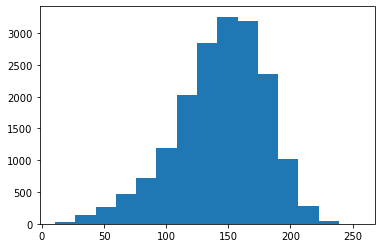

In [17]:
plt.hist(common.yields,15)

## Create longitudinal data 

grid to add temporal lags and ensure missing values are observed


In [19]:
common_dictionary = {'adm2_code' : common.adm2_code.unique().tolist(),
                     'year' : common.year.unique().tolist()}

common_df = expand_grid(common_dictionary)


daily_dictionary = {'adm2_code' : daily.adm2_code.unique().tolist(),
                    'year' : daily.year.unique().tolist(),
                    'doy' : daily.doy.unique().tolist()}

daily_df = expand_grid(daily_dictionary)


# merge data into expanded grid 
common_df = pd.merge(common_df, common, how='left', on=['adm2_code', 'year'])
daily_df = pd.merge(daily_df, daily, how='left', on=['adm2_code', 'year','doy'])


# build lagged yield feature 
common_df_lag = buildLaggedFeatures(common_df[['yields']],lag=2,dropna=False).drop(columns=['yields'])
common_df_lag = common_df.join(common_df_lag)

# correct state codes 
common_df_lag['adm1_code'] = common_df_lag['adm2_code'].str[:4]

# drop years with misssing yields (for later use)
common_df_lag.dropna(subset=['yields'], inplace=True)
common_df_lag.to_csv('../data/common_data_expanded_lag.csv')

# cleanup 
del(common,daily)

In [21]:
#%%  check for missing dependent variables
yields_missing =  count_missing_by(yields,'yields','year')
print(yields_missing.head())

   year  count
0  1990      0
1  1991      0
2  1992      0
3  1993      0
4  1994      0


In [22]:
common_missing = count_missing_by(common_df,'yields','year')
print(common_missing.head())

   year  count
0  2003     70
1  2004     66
2  2005     63
3  2006     98
4  2007     22


In [23]:
#%% check for missing data in daily using example
daily_missing_year = count_missing_by(daily_df,'met_gdd','year')                        
print(daily_missing_year.head())

# take away missing data fairly evenly distribed, should check if there is any systematic bias, 
# SMOTE or stratified samples might correct for years with more missing data 

   year  count
0  2003  25550
1  2004  24090
2  2005  22995
3  2006  35770
4  2007   8030


In [24]:
#%% check if observations are biased towards a certain time of year
daily_missing_day =  count_missing_by(daily_df,'met_gdd','doy')
print(daily_missing_day['count'].describe())

# missing data present in daily observatios but not systematically biased. 
# needs more work but moving on 

count     365.0
mean     1618.0
std         0.0
min      1618.0
25%      1618.0
50%      1618.0
75%      1618.0
max      1618.0
Name: count, dtype: float64


## Interpolation of time series 

1) remove groups with minimal valid observations before interpolation

In [ ]:
# see if counties have significant missing 
daily_missing_code =  count_missing_by(daily_df,'met_gdd','adm2_code')
print(daily_missing_code['count'].describe())


# find all groups with greater than 100 missing values per year for each column
empty_codes = [ missing_group(df = daily_df,
                              group = 'adm2_code', 
                              column = col, 
                              min_missing = len(daily_df.year.unique()) * 100 ) 
              for col in daily_df.columns ]

empty_codes = list(set(chain(*empty_codes)))

# again this isn't totally ideal but minimized the effects of sparse observations


#%%  remove counties with signifincant missing data 
print('removing ', len(empty_codes)/len( daily_df.adm2_code.unique() ) *100,'% of counties that have sig missing data ' )

daily_df = daily_df[~daily_df.adm2_code.isin(empty_codes)]

# check missing values
print(daily_df.isnull().sum())


2) interpolate linearly across time by county

In [ ]:
#%%  linear interpolation between observations 

for col in daily_df.columns[4:]:
        print('-------', col)
        daily_df[col] = daily_df.groupby(['adm2_code'],group_keys=False)\
                        .apply(lambda group: group[col] \
                               .interpolate(method='linear',
                                            limit_direction = 'both'))

print(daily_df.isnull().sum())

# this step might require more effort some features might not interp well linearly
# should use minimum # observations but skipping for time


#%% create period for code for year_doy groups  
daily_df['time'] = daily_df['year']*1000+ daily_df['doy']
daily_df.drop(columns=['date'], inplace=True)

#%% writeout for cleanup 
daily_df.to_csv('../data/daily_clean.csv', chunksize = 1e4, index=False)

## Principals driving feature extraction approach

Temporal feature extraction is the critical component of this exercise. Although my current workflow doesn't fully comprise my objective, I view this process a little bit differently than most RS experts. 

Primary differences:
- Ecosystems are driven by integrative processes
    - Soil moisture (or lack there of) accumulates over longer time periods
    - Good and bad management has cumulative effects esp in developing countries
- Management practices matter
    - Use of no till and cover crops can have important effects on subsequent time periods
    - Practices like soil augmentation can have effects lasting nearly a decade 
    - Dual cropping / irrigation etc
- Spatial and time should be leveraged and feared
    - T+1 is often a function of previous year
    - Spatial autocorrelation can interfer with oos performance measures (same event can effect multiple years) 
    - Location matters, eastern CO and western KA are at the edge of ogallala and experience irrigation failue

In this case I make a choice not to filter out observations outside of the primary growing season. This is because what happens outside of the growing period can be a important as during, esp in areas with limited irrigation. Although these periods should be handled seperately, I don't in this case because of time constraints. This approach should be compared to traditional ones that filter out non-growing periods from the sample.



In [ ]:
#%%  Break files into chunks for feature extraction 

# use dask to create data partitions 
daily_df = dd.read_csv('../data/daily_clean.csv', blocksize=16*365*5000)
daily_df.to_csv('../data/dailychunks/daily_*.csv')

### Feature extraction
Features were extracted on a year by year basis. This is a targeted set out of dozens of options.  Lags can be used to estimate effects of temporal spillovers. 

List of temporal features by type:

- Numeric
    - mean / max / median / min / sd / sum
    - max and min slope observed in a 30 day periods
    - doy location of max and min
    - longest period above and below the mean 
    - count above and below the mean
    
    
- Categorical
    - sum / sd 
    - longest period above and below the mean 

NOTE: I am redacting this section of the code. What's life without a little mystery? 


In [ ]:
Redacted 

## Predictive model 

In the following section I utilize a variety of techniques to ensure a high quality model, and meaningful measures of accuracy. 

This approach includes:

- Stratification of testing training split
- Sklearn pipelines for data preperation and tuning
- Tuning through cross validation 
- Leave one out (year) estimates of OOS performance
- Best model prediction for 2018

### Model data preparation 

In [76]:
os.chdir('/home/mmann/Documents/Github/Indigo_Yield/indigo_yield')

# to make this notebook's output stable across runs
np.random.seed(42)


# combine various input data
common_df = pd.read_csv('../data/common_data_expanded_lag.csv',index_col=0)
common_df['id'] = common_df["adm2_code"]+ "_" + common_df["year"].map(str)  # update index to include year 

# read in extracted features 
features_df = dd.read_csv('../data/features/daily_*.csv').compute()

# merge inner to avoid dropped counties 
merge_df = pd.merge(common_df, features_df, on='id', how='inner')
merge_df.drop(columns=['id','adm2_code','area_harvested_obs'], inplace=True)  # drop county for OOS preds


#%% out of sample and testing training split

#remove 2018
merge_df = merge_df.loc[merge_df.year != 2018 ]

#####

# generate state codes for stratification # climatic zones might be better 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(merge_df, merge_df["adm1_code"]):
    strat_train_set = merge_df.iloc[train_index]
    strat_test_set = merge_df.iloc[test_index]
   
    
#%% Add additional variables and prep

y_train = strat_train_set["yields"].copy()
X_train = strat_train_set.drop("yields", axis=1) # drop labels for training set

y_test = strat_test_set["yields"].copy()
X_test = strat_test_set.drop("yields", axis=1)

In [77]:
#%% Generate preprocessing and model pipelines 

# set up pipelines for preprocessing categorical and numeric data 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])  # not needed in this case but good for nontree models
    
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
     
    
# isolate numeric and categorical data
numeric_features = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
categorical_features = list( X_train.select_dtypes(include=['object']).columns)


# define preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])
 
# test it works 
X_train_prepared = preprocessor.fit_transform(X_train)

In [ ]:
# create model tuning pipeline 
full_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('randomforest', RandomForestRegressor(random_state=42))
                            ])

parameters = {'randomforest__n_estimators': [100,500],
          'randomforest__criterion':['mse','mae'],
          'randomforest__min_samples_split': [2,5,10,50,100],
          'randomforest__max_features' : ['sqrt',5,10,15,20]
          }
 
   
grid_search = GridSearchCV(full_pipe, parameters, 
                           cv=5, # want to do stratified split but havent figured out 
                           n_jobs=-1,
                           verbose=2, 
                           scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

Note: given the nature of the exercise cv method should likely be hold one out by year. In this case I didn't have time to figure out how to pass the year (groups) to the pipeline. Instead, although not ideal, we will use hold one out in our cross validation score later once ideal parameters have been chosen. 

In [33]:
# save & load model outputs 
joblib.dump(grid_search, '../data/models/grid_search_rf.pkl')
grid_search = joblib.load('../data/models/grid_search_rf.pkl')
grid_search.best_params_


{'randomforest__criterion': 'mse',
 'randomforest__max_features': 20,
 'randomforest__min_samples_split': 2,
 'randomforest__n_estimators': 100}

## Accuracy assessment 

In this case it is critical to look at out of sample accuracy assessments from a few lenses.

These include:

- Training period out of sample observations - meaningful for unobserved locations
- Leave one group out (year) cross validation - meaningful for unobserved time periods 

In [46]:
#%% Test "in period" out of sample accuracy 
y_pred = grid_search.predict(X_test)

print('OOS Explained variance  ' + str(round(r2_score(y_test, y_pred),3)*100)+'%')
print('OOS Mean abs error  ' + str(round(median_absolute_error(y_test, y_pred),3))+' bushels/acre')
print('OOS Mean abs error  ' + str(round(max_error(y_test, y_pred),3))+' bushels/acre')


OOS Explained variance  84.3%
OOS Mean abs error  7.997 bushels/acre
OOS Mean abs error  75.952 bushels/acre


In [56]:
#%% check predictive accuracy using one year holdouts unbiased

X = merge_df.drop(columns='yields')
y =  merge_df["yields"]
groups =  merge_df["year"]

logo=LeaveOneGroupOut().split(X, y, groups)

scores = cross_val_score(grid_search.best_estimator_, X, y, cv=logo , scoring='r2', n_jobs=-1)
scores2 = cross_val_score(grid_search.best_estimator_, X, y, cv=logo, n_jobs=-1)


In [51]:
hold_one_year = stats.describe(scores) 
hold_one_year

DescribeResult(nobs=15, minmax=(0.415880226691707, 0.7363979894063244), mean=0.6105827722487507, variance=0.008747055577258212, skewness=-0.6449711143199929, kurtosis=-0.620220263199065)

Not surprisingly hold one out year performance declines relative to in-period results. We can expect on average to explain around 61% of the variance with the model in its current form. 

Strategies for model improvement:
- Tuning with hold one year out splits in CV
- Breaking year into pre- and primary growing seasons, do feature extraction for both
- Add additional time series features of interest (but not on my old laptop)
    - Guided by feature significance
- Stratification of testing training split by yield class (make sure low yeilds are represented)
- Feature filtering 
- Have more time to work on it!

## 2018 Prediction

The final task then is to make our out of sample predictions for the new year. 

In [91]:
pred_2018 = pd.read_csv('../data/pred_2018')
pred_2018['yield_pred'] = grid_search.predict(pred_2018)
pred_2018[['adm1_code','year','yield_pred']].to_csv('../predictions_2018.csv')

## Exploring predictions
Although I don't have much time to spend here. Its worth looking at our results relative to actual, examine trends etc. 

In [92]:
# apply preprocess transform and predict 
merge_df['yield_pred'] = grid_search.predict(merge_df)

In [118]:
pred_combine = merge_df[['year','yield_pred']].append(pred_2018[['year','yield_pred']])
#pred_combine.set_index('year', inplace=True)
pred_combine.head()

,year,yield_pred
0,2003,154.812
1,2004,144.913
2,2005,141.921
3,2006,87.857
4,2007,93.608


In [160]:
from plotnine import *
common = pd.read_csv('../data/common_data.csv')
common.head()

/home/mmann/anaconda3/envs/indigo_yield/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 1292 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


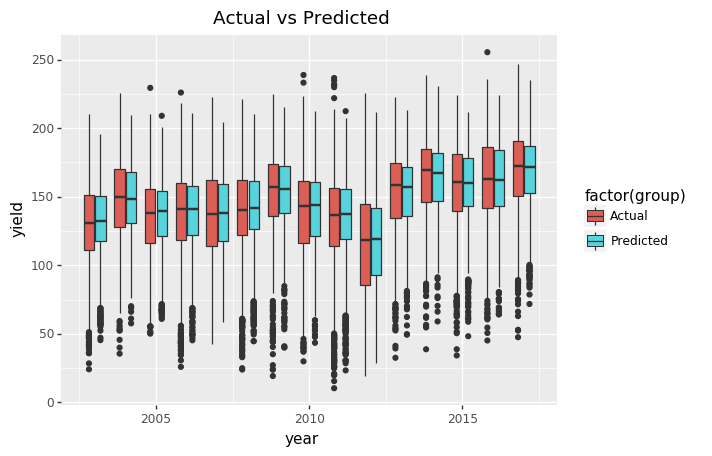

<ggplot: (8747893043439)>

In [154]:
common['group2'] = 'one'+common["year"].map(str)
merge_df['group2'] = 'two'+merge_df["year"].map(str)
common['group'] = 'Actual'
merge_df['group'] = 'Predicted'

merge_df['yield'] = merge_df['yield_pred']
all_yield = merge_df[['year','yield','group','group2']].append(common[['year','yield','group','group2']])

ggplot(all_yield) + geom_boxplot( aes(x='year', y='yield',fill='factor(group)',group='factor(group2)'))+ggtitle('Actual vs Predicted')


/home/mmann/anaconda3/envs/indigo_yield/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1292 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


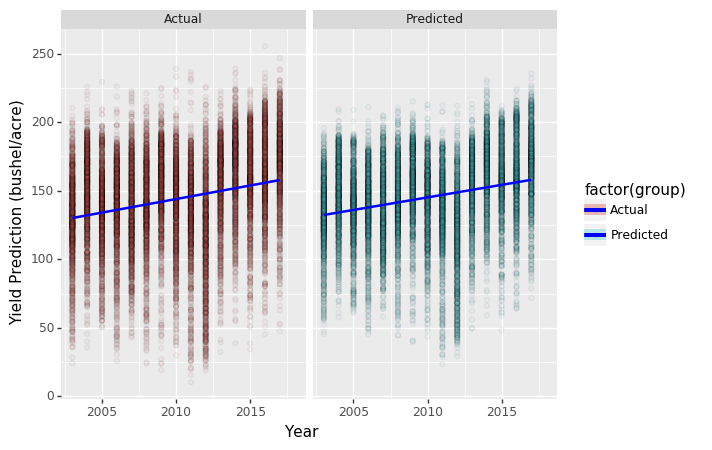

<ggplot: (8747893811839)>

In [159]:
ggplot(aes(x='year', y='yield',fill='factor(group)'), data=all_yield) +\
    geom_point(alpha=0.05) +\
    stat_smooth(method='lm',color='blue')+xlab('Year')+ylab('Yield Prediction (bushel/acre)')+\
    facet_wrap('group')

We can see however that we have replicated important trends and variability across years. Parametric tests should be preformed to ensure that trend lines are statistically identical. 